# Figure S16. Effects of varying Gaussian noise seed in optimal simulations of the main run

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pickle
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data of the main run and select the 200 subsample subjects:

In [3]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

# limit the optima to subsample
subsample = np.loadtxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), dtype=str)
subjects_optima = subjects_optima.loc[subjects_optima['sub'].isin(subsample)]

# select optimal runs and add demographics
best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# load I_E of optimal runs
I_E = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        I_E.loc[sub, parc] = regional_vars[sub][row['SeedMW']].loc[i, 'I_E']

Split data into two age groups for comparing ICCs between them:

In [4]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

Load the simulation data of alternative seeds:

In [5]:
orig_seed = 410
alt_seeds = list(range(50))

all_seed_IE = {}
all_seed_fits = {}
for rand_seed in [orig_seed]+alt_seeds:
    base_dir = os.path.join('./sim_seed', f'SeedSim-{rand_seed}')
    sim_states = np.load(os.path.join(base_dir, 'states.npz'))
    all_seed_IE[rand_seed] = pd.DataFrame(sim_states['I_E'], index=data.index, columns=parcels)
    scores = pd.read_csv(os.path.join(base_dir, 'scores.csv'), index_col=0)
    # make the cubnm gof measures comparable to the main results (without -/+ signs)
    scores[['-fc_diff', '-fcd_ks']] = -scores[['-fc_diff', '-fcd_ks']]
    scores.columns = [s.replace('-','').replace('+','') for s in scores.columns]
    all_seed_fits[rand_seed] = scores

## A. Goodness-of-fit comparison

Calculate the median of their GOF measures:

In [6]:
orig_fits = all_seed_fits[orig_seed]
median_fits = {}
for sub in data.index:
    sub_fits = {}
    for seed in alt_seeds:
        sub_fits[seed] = all_seed_fits[seed].loc[sub]
    median_fits[sub] = pd.DataFrame(sub_fits).median(axis=1)
median_fits = pd.DataFrame(median_fits).T

Compare GOF of original seed and alternative seeds:

In [7]:
gof_labels = {
    'gof': 'Goodness-of-fit',
    'fc_corr': 'FC correlation',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

Goodness-of-fit	31.064	0.0	0.101	0.046
FC correlation	8.946	0.0	0.011	0.018
FC difference	-7.272	0.0	-0.009	0.018
FCD KS distance	-26.615	0.0	-0.078	0.042


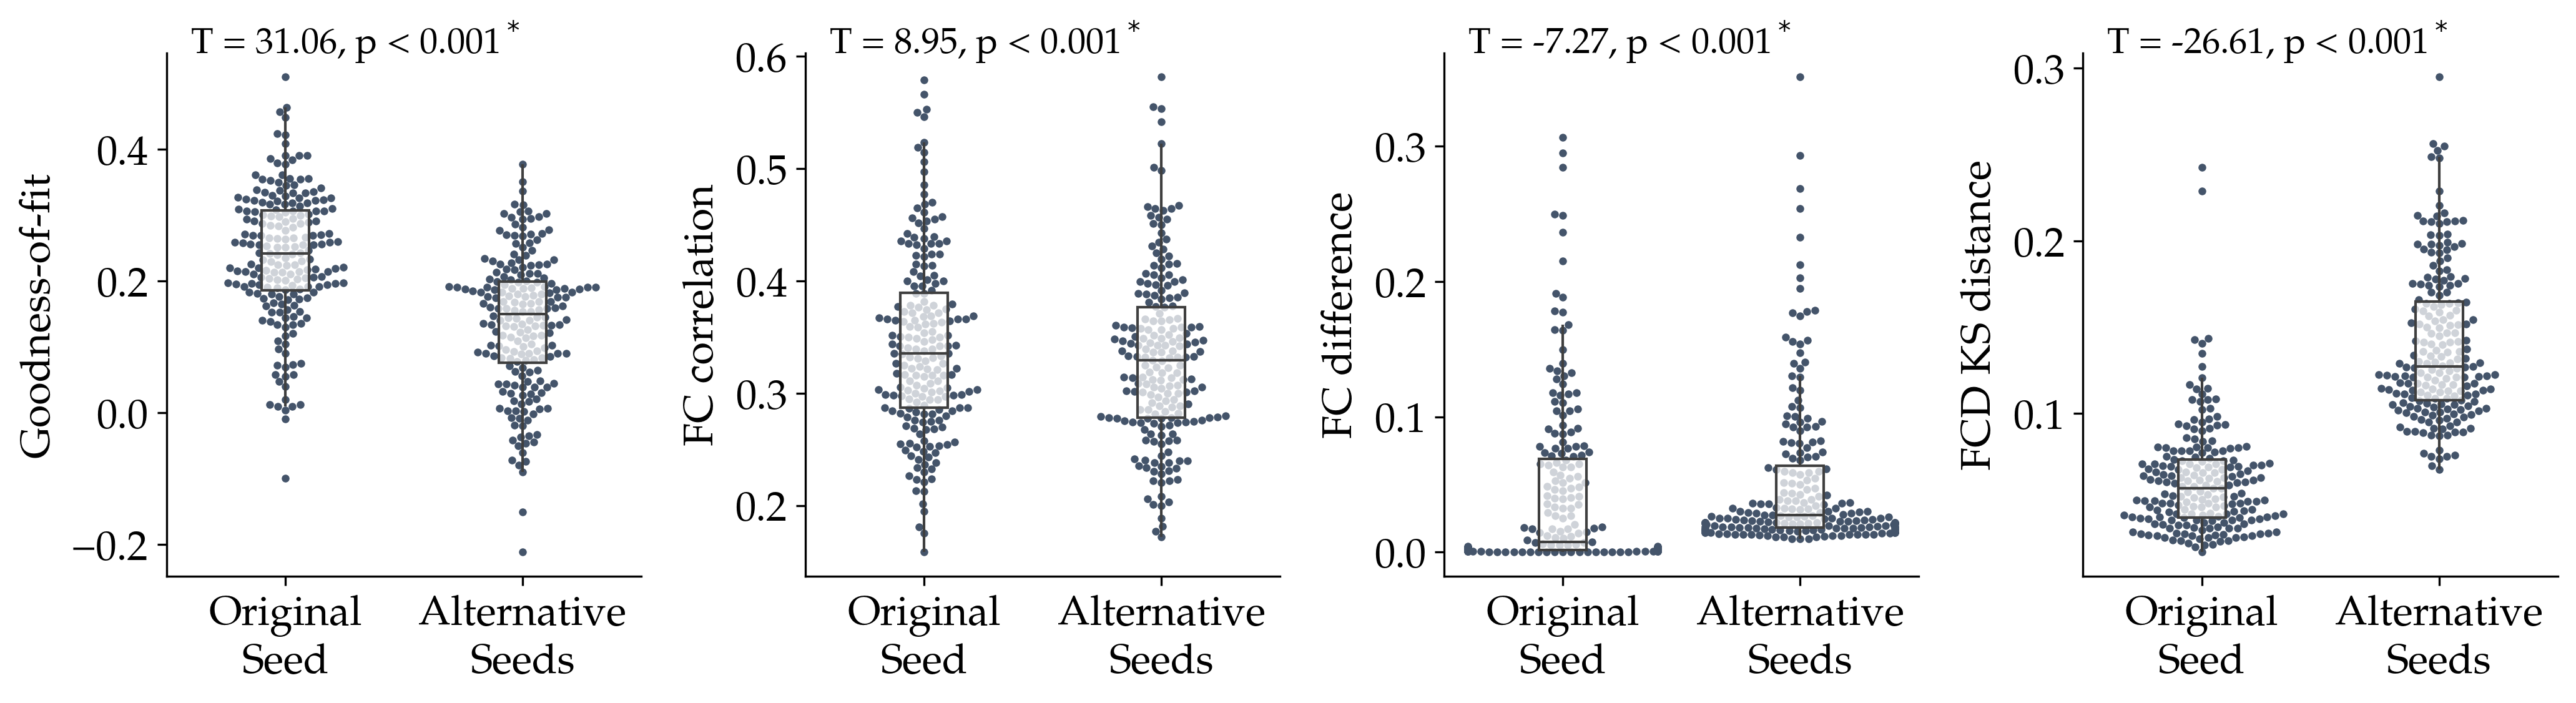

In [8]:
fig, axes = plt.subplots(1, len(gof_labels), figsize=(14, 4))
for i, (col, label) in enumerate(gof_labels.items()):
    ax = axes[i]
    plot_data = pd.DataFrame({'orig': orig_fits[col], 'alt': median_fits[col]}).unstack().reset_index()
    sns.swarmplot(
        data=plot_data,
        x='level_0', y=0,
        s=3, color=thcolor,
        ax=ax
    )
    sns.boxplot(
        data=plot_data,
        x='level_0', y=0,
        showfliers=False,
        showcaps=False, width=0.2,
        boxprops={"facecolor": (1, 1, 1, 0.75)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label)
    ax.set_xticklabels(['Original\nSeed', 'Alternative\nSeeds'])
    ax.set_xlabel('')
    sns.despine()
    # add statistics
    t, p = scipy.stats.ttest_rel(orig_fits[col], median_fits[col])
    mean_diff = (orig_fits[col] - median_fits[col]).mean()
    sd_diff = (orig_fits[col] - median_fits[col]).std()
    if add_text:
        if p > 0.001:
            text = f'T = {t:.2f}, p = {p:.3f}'
        else:
            text = f'T = {t:.2f}, p < 0.001'
        if p < 0.05:
            text+=r'$^*$'
        text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
        text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
        ax.text(text_x, text_y, 
                text,
                color='black',
                size=14,
                multialignment='left')
    print(label, round(t, 3), round(p,3), round(mean_diff, 3), round(sd_diff, 3), sep="\t")
fig.tight_layout(pad=1.0)

## B. Node-level intraclass correlation of E-I ratio

In [9]:
icc_seed = pd.DataFrame(index=parcels, columns=range(50), dtype=float)
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(
            {'orig': all_seed_IE[orig_seed].iloc[:, i], rand_seed: all_seed_IE[rand_seed].iloc[:, i]},
            index=data.index, dtype=float
        )
        icc_seed.loc[parc, rand_seed] = stats.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, rand_seed])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.30it/s]


In [10]:
icc_seed.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.784264,0.794385,0.769631,0.777404,0.775078,0.711870,0.793264,0.781256,0.706445,0.789341,...,0.759860,0.758791,0.789941,0.737971,0.819788,0.805344,0.747840,0.753063,0.739244,0.784236
std,0.164396,0.177799,0.178319,0.173264,0.192499,0.261602,0.194016,0.177168,0.275782,0.166869,...,0.201219,0.214007,0.174901,0.213807,0.151227,0.154012,0.236127,0.160204,0.198374,0.177059
min,0.136539,-0.016353,0.025311,-0.257562,-0.317577,-0.368738,-0.228397,0.027867,-0.447385,0.036415,...,-0.125790,-0.187632,0.181162,-0.085031,0.308598,0.279834,-0.316316,0.046292,-0.209081,0.044760
25%,0.734250,0.716744,0.693706,0.719341,0.733717,0.684029,0.762565,0.765299,0.665107,0.749281,...,0.698405,0.712034,0.754764,0.691339,0.771986,0.763357,0.690435,0.700309,0.686860,0.739407
50%,0.840305,0.860392,0.831758,0.809860,0.832847,0.786709,0.844855,0.834108,0.799856,0.826324,...,0.818582,0.830061,0.843526,0.803354,0.872364,0.850365,0.814018,0.806824,0.802774,0.837456
75%,0.897008,0.905346,0.892954,0.904311,0.893097,0.870771,0.913237,0.884454,0.865569,0.900405,...,0.887794,0.898969,0.900332,0.869858,0.926978,0.908803,0.898200,0.859145,0.870510,0.906224
max,0.973378,0.977682,0.977519,0.973548,0.956044,0.955246,0.977766,0.957184,0.966089,0.969887,...,0.980751,0.962896,0.967407,0.959632,0.978639,0.972521,0.964847,0.934879,0.978531,0.975022


Take median across 50 random seeds

In [11]:
icc_seed_median = icc_seed.median(axis=1)

Comparison of ICC between younger and older age groups:

In [12]:
# calculate ICC by age in each alternative seed vs original seeds
icc_seed_by_age = {
    'younger': pd.DataFrame(index=parcels, columns=range(50), dtype=float),
    'older': pd.DataFrame(index=parcels, columns=range(50), dtype=float)
}
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(
            {'orig': all_seed_IE[orig_seed].iloc[:, i], rand_seed: all_seed_IE[rand_seed].iloc[:, i]},
            index=data.index, dtype=float
        )
        for age in data_by_age.keys():
            subs = data_by_age[age].index
            icc_seed_by_age[age].loc[parc, rand_seed] = stats.madicc(icc_df.loc[subs, 'orig'], icc_df.loc[subs, rand_seed])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


       younger    older      all
count  100.000  100.000  100.000
mean     0.804    0.801    0.810
std      0.115    0.097    0.100
min      0.323    0.412    0.368
25%      0.785    0.764    0.787
50%      0.835    0.826    0.839
75%      0.863    0.864    0.869
max      0.948    0.941    0.929
T =0.3005568688758825, p = 0.7643826865229977


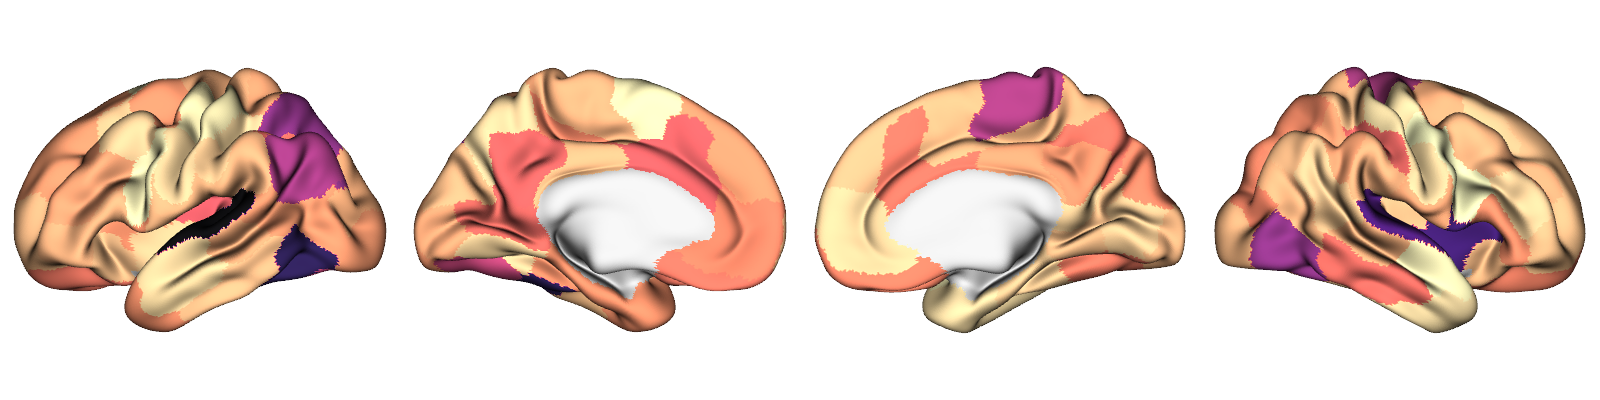

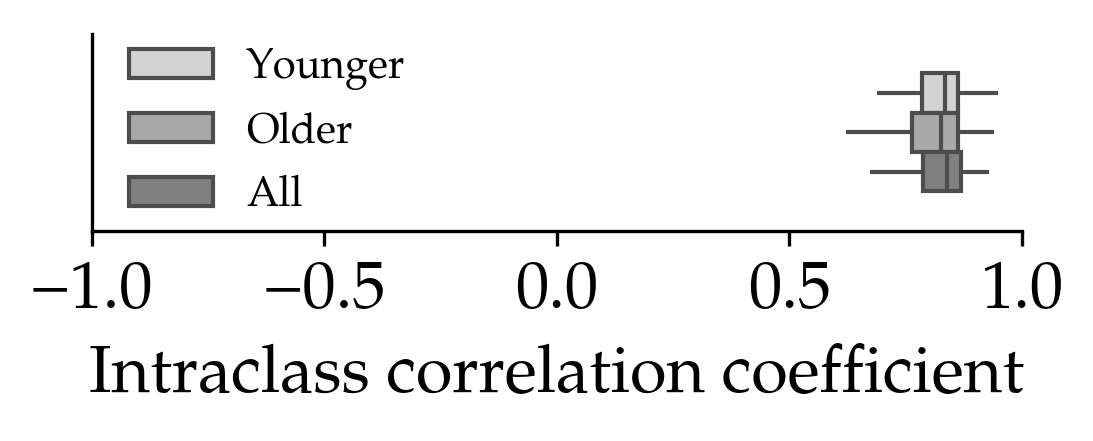

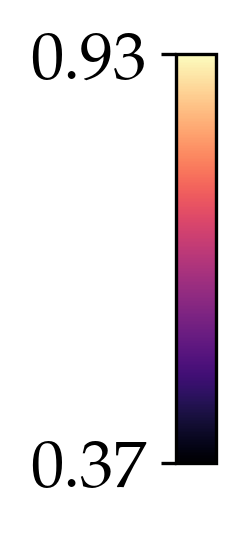

In [13]:
icc_seed_by_age_median = pd.DataFrame({k: v.median(axis=1) for k, v in icc_seed_by_age.items()})
icc_seed_by_age_median['all'] = icc_seed_median
print(icc_seed_by_age_median.describe().round(3))
plot.plot_icc_by_age(icc_seed_by_age_median, 'schaefer-100')